# Imports and Constant

In [1]:
import cv2
import os
#from google.colab.patches import cv2_imshow
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold

In [2]:
HALFDATASETSIZE = 1340
EPOCHS = 10
LEARNING_RATE = 0.01
BATCH_SIZE = 32
MOMENTUM = 0.9
NUM_FOLDS = 5

# Data recovery

Connexion to drive

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
#import os
#os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive"

In [5]:
#!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [6]:
#import zipfile
#for file in os.listdir():
    #if file.endswith(".zip"):
       #with zipfile.ZipFile(file, "r") as zip_file:
            #zip_file.extractall()
        #os.remove(file)

Data Access

In [7]:
folder_path = 'chest_xray/train/PNEUMONIA'

image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpeg')] #pictures names
print("number of pictures in the file :", len(image_files))

sizes = []
k = 0
for file_name in image_files:
    k += 1
    file_path = os.path.join(folder_path, file_name)
    image = cv2.imread(file_path)

    sizes.append(image.shape)

    if k == 10 :
      break

print(sizes)


number of pictures in the file : 3875
[(760, 1152, 3), (768, 1072, 3), (863, 1244, 3), (940, 1242, 3), (1280, 1488, 3), (616, 1008, 3), (816, 1184, 3), (480, 856, 3), (888, 1048, 3), (792, 1216, 3)]


Example on one picture:

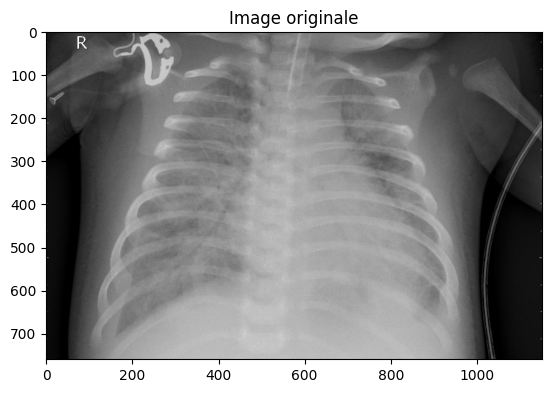

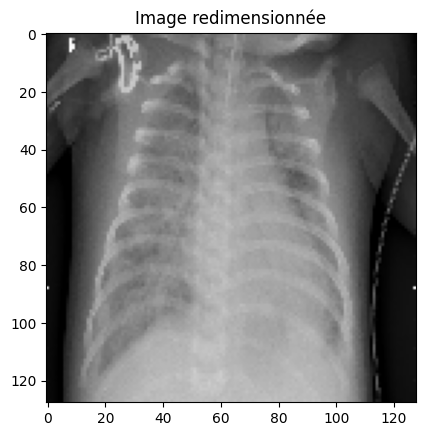

In [8]:
filename = image_files[0]
file_path = os.path.join(folder_path, filename)
image = cv2.imread(file_path)
plt.imshow(image)
plt.title("Image originale")
plt.show()
resized_image = cv2.resize(image, (128, 128))
plt.imshow(resized_image)
plt.title("Image redimensionnée")
plt.show()

In [9]:
r = np.array(image[:,:,0])
g = np.array(image[:,:,1])
b = np.array(image[:,:,2])

print(r[:10,:10])
print(g[:10,:10])
print(b[:10,:10])

[[19 19 18 18 18 19 20 20 21 24]
 [19 19 18 18 18 19 20 21 21 24]
 [19 19 18 18 19 20 21 21 22 24]
 [19 19 18 19 19 20 22 22 23 24]
 [19 19 19 19 20 21 23 23 24 24]
 [19 18 19 19 20 22 23 24 24 24]
 [18 18 19 19 21 22 24 25 25 24]
 [18 18 19 20 21 23 24 25 26 24]
 [20 21 22 23 24 25 24 24 27 26]
 [20 21 22 23 24 24 24 24 28 27]]
[[19 19 18 18 18 19 20 20 21 24]
 [19 19 18 18 18 19 20 21 21 24]
 [19 19 18 18 19 20 21 21 22 24]
 [19 19 18 19 19 20 22 22 23 24]
 [19 19 19 19 20 21 23 23 24 24]
 [19 18 19 19 20 22 23 24 24 24]
 [18 18 19 19 21 22 24 25 25 24]
 [18 18 19 20 21 23 24 25 26 24]
 [20 21 22 23 24 25 24 24 27 26]
 [20 21 22 23 24 24 24 24 28 27]]
[[19 19 18 18 18 19 20 20 21 24]
 [19 19 18 18 18 19 20 21 21 24]
 [19 19 18 18 19 20 21 21 22 24]
 [19 19 18 19 19 20 22 22 23 24]
 [19 19 19 19 20 21 23 23 24 24]
 [19 18 19 19 20 22 23 24 24 24]
 [18 18 19 19 21 22 24 25 25 24]
 [18 18 19 20 21 23 24 25 26 24]
 [20 21 22 23 24 25 24 24 27 26]
 [20 21 22 23 24 24 24 24 28 27]]


# Balancing of the dataset

In [10]:
folder_path_train_P = 'chest_xray/train/PNEUMONIA'
folder_path_train_N = 'chest_xray/train/NORMAL'
folder_path_test_P = 'chest_xray/test/PNEUMONIA'
folder_path_test_N = 'chest_xray/test/NORMAL'

image_files_train_P = [f for f in os.listdir(folder_path_train_P) if f.endswith('.jpeg')]
image_files_train_N = [f for f in os.listdir(folder_path_train_N) if f.endswith('.jpeg')]
image_files_test_P = [f for f in os.listdir(folder_path_test_P) if f.endswith('.jpeg')]
image_files_test_N = [f for f in os.listdir(folder_path_test_N) if f.endswith('.jpeg')]

print("nombre d'images train P :", len(image_files_train_P))
print("nombre d'images train N :", len(image_files_train_N))
print("nombre d'images test P :", len(image_files_test_P))
print("nombre d'images test N :", len(image_files_test_N))

nombre d'images train P : 3875
nombre d'images train N : 1341
nombre d'images test P : 390
nombre d'images test N : 234


In [11]:
image_files_train_P = image_files_train_P[:HALFDATASETSIZE]
image_files_train_N = image_files_train_N[:HALFDATASETSIZE]

# Balancing of the test

In [12]:

image_files_test_P = image_files_test_P[:234]

print("nombre d'images test P :", len(image_files_test_P))
print("nombre d'images test N :", len(image_files_test_N))

nombre d'images test P : 234
nombre d'images test N : 234


# Pytorch Dataset

In [13]:
def load_images(folder_path, filenames):
    images = []
    for filename in filenames:
        img = cv2.imread(os.path.join(folder_path, filename))
        if img is not None:
            img = img[:,:,0] #On garde 1 channel
            img = cv2.resize(img, (128, 128)) #format = (128,128)
            img = np.expand_dims(img, axis=0) #format = (1,128,128)
            images.append(img)
    return images

In [14]:
images_train_P = load_images(folder_path_train_P, image_files_train_P)
images_train_N = load_images(folder_path_train_N, image_files_train_N)
images_test_P = load_images(folder_path_test_P, image_files_test_P)
images_test_N = load_images(folder_path_test_N, image_files_test_N)

We will now mix the PNEUMONIA and NORMAL, and create the labels, 0 for NORMAL, 1 for PNEUMONIA.

In [15]:
train_images = images_train_P + images_train_N
test_images = images_test_P + images_test_N

train_labels = [1 for i in range(len(images_train_P))] + [0 for i in range(len(images_train_N))]
test_labels = [1 for i in range(len(images_test_P))] + [0 for i in range(len(images_test_N))]

The lists are not yet mixed. We need to keep the correspondence between data and labels during blending.

In [16]:
train_data = list(zip(train_images, train_labels))
test_data = list(zip(test_images, test_labels))

random.shuffle(train_data)
random.shuffle(test_data)

train_images, train_labels = zip(*train_data)
test_images, test_labels = zip(*test_data)

In [17]:
train_images = np.array(train_images).astype(np.float32)
train_labels = np.array(train_labels).astype(np.float32)
test_images = np.array(test_images).astype(np.float32)
test_labels = np.array(test_labels).astype(np.float32)

Normalization, otherwise it won't work (pytorch wants values between 0 and 1).

In [18]:
train_images = train_images/255
test_images = test_images/255

Transition to pytorch tensor :

In [19]:
#train_images_tensor = torch.tensor(train_images, dtype=torch.float)
#train_labels_tensor = torch.tensor(train_labels, dtype=torch.float)
#test_images_tensor = torch.tensor(test_images, dtype=torch.float)
#test_labels_tensor = torch.tensor(test_labels, dtype=torch.float)

# Model

Model definition

In [20]:
class Net(nn.Module) :
  def __init__(self) :
    super().__init__()
    self.conv1 = nn.Conv2d(1,32,3,padding='same')
    self.activ1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2)

    self.conv2 = nn.Conv2d(32,64,3,padding='same')
    self.activ2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(2)

    self.conv3 = nn.Conv2d(64,128,3,padding='same')
    self.activ3 = nn.ReLU()
    self.pool3 = nn.MaxPool2d(2)

    self.conv4 = nn.Conv2d(128,256,3,padding='same')
    self.activ4 = nn.ReLU()
    self.pool4 = nn.MaxPool2d(2)

    self.flatten = nn.Flatten()
    self.dense1 = nn.Linear(256 * 8 * 8, 256)
    self.activ5 = nn.ReLU()
    self.dense2 = nn.Linear(256, 128)
    self.activ6 = nn.ReLU()
    self.dense3 = nn.Linear(128, 1)
    self.sigmoid = nn.Sigmoid()



  def forward(self, x) : # dimension de x : (128,128), en général je met les dimensions en sortie de couche après la couche.
    x = self.conv1(x)
    #taille 32,128,128
    x = self.activ1(x)
    x = self.pool1(x)
    #taille 32,64,64

    x = self.conv2(x)
    #taille 64,64,64
    x = self.activ2(x)
    x = self.pool2(x)
    #taille 64,32,32

    x = self.conv3(x)
    #taille 128,32,32
    x = self.activ3(x)
    x = self.pool3(x)
    #taille 128,16,16

    x = self.conv4(x)
    #taille 256,16,16
    x = self.activ4(x)
    x = self.pool4(x)
    #taille 256,8,8

    x = self.flatten(x)
    #taille 256 * 8 * 8
    x = self.dense1(x)
    #taille 256
    x = self.activ5(x)
    x = self.dense2(x)
    #taille 128
    x = self.activ6(x)
    x = self.dense3(x)
    #taille 1
    x = self.sigmoid(x)

    return x.squeeze() # le squeeze enlève tous les 1 des dimensions

Network based on the model

In [21]:
my_nn = Net()
print(my_nn)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (activ1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (activ2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (activ3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (activ4): ReLU()
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=16384, out_features=256, bias=True)
  (activ5): ReLU()
  (dense2): Linear(in_features=256, out_features=128, bias=True)
  (activ6): ReLU()
  (dense3): Linear(in_features=128, out_features=1, bias=

Loss definition

In [22]:
criterion = nn.BCELoss()

Optimizer 

In [23]:
optimizer = optim.SGD(my_nn.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# Training

In [24]:
# Initialize KFold
kf = KFold(n_splits=NUM_FOLDS)

In [25]:
for fold, (train_index, val_index) in enumerate(kf.split(train_images)):
    print(f'Fold {fold + 1}/{NUM_FOLDS}')
    
    # Split data
    train_images_fold = train_images[train_index]
    train_labels_fold = train_labels[train_index]
    val_images_fold = train_images[val_index]
    val_labels_fold = train_labels[val_index]

    

    # Convert back to tensors
    train_images_fold_tensor = torch.tensor(train_images_fold, dtype=torch.float32)
    train_labels_fold_tensor = torch.tensor(train_labels_fold, dtype=torch.float32)
    val_images_fold_tensor = torch.tensor(val_images_fold, dtype=torch.float32)
    val_labels_fold_tensor = torch.tensor(val_labels_fold, dtype=torch.float32)
    
    for epoch in range(EPOCHS):
        running_loss = 0.0
        running_correct = 0
        dataloader = tqdm(range(0, len(train_images_fold_tensor), BATCH_SIZE), position=0, leave=True)

        for i in dataloader:
            inputs = train_images_fold_tensor[i:i+BATCH_SIZE]
            labels = train_labels_fold_tensor[i:i+BATCH_SIZE]

            #Ici on réinitialise les gradients
            optimizer.zero_grad()

            outputs = my_nn(inputs)
            #print(outputs.shape)
            #print(labels.shape)
            loss = criterion(outputs,labels)

            #Ici on calcule la loss (et les gradients en passant)
            loss.backward()

            #Ici on mets à jour les poids selon les gradients calculés
            optimizer.step()

            #Ici on met à jour running_loss pour l'affichage
            running_loss += loss.item()

            predicted = (outputs>0.5).int()
            running_correct += (predicted == labels).int().sum()

            dataloader.set_description(f'Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss/len(train_images_fold_tensor):.6f}, Accuracy : {100*running_correct/len(train_images_fold_tensor):.1f}%')
            dataloader.refresh()

    dataloader.close()

    # Validation phase
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for i in range(0, len(val_images_fold_tensor), BATCH_SIZE):
            inputs = val_images_fold_tensor[i:i+BATCH_SIZE]
            labels = val_labels_fold_tensor[i:i+BATCH_SIZE]

            outputs = my_nn(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs>0.5).int()
            val_correct += (predicted == labels).int().sum()
            

    print(f'Fold {fold + 1}/{NUM_FOLDS} - Validation Loss: {val_loss/len(val_images_fold_tensor):.5f}, Validation Accuracy : {100*val_correct/len(val_images_fold_tensor):.1f}%')

print('Cross-validation finished')

Fold 1/5


Epoch 10/10, Loss: 0.002719, Accuracy : 96.5%: 100%|██████████| 67/67 [00:58<00:00,  1.14it/s]


Fold 1/5 - Validation Loss: 0.00808, Validation Accuracy : 92.5%
Fold 2/5


Epoch 10/10, Loss: 0.001328, Accuracy : 98.1%: 100%|██████████| 67/67 [01:00<00:00,  1.11it/s]


Fold 2/5 - Validation Loss: 0.00317, Validation Accuracy : 97.0%
Fold 3/5


Epoch 10/10, Loss: 0.000423, Accuracy : 99.4%: 100%|██████████| 67/67 [00:59<00:00,  1.12it/s]


Fold 3/5 - Validation Loss: 0.00076, Validation Accuracy : 99.3%
Fold 4/5


Epoch 10/10, Loss: 0.000009, Accuracy : 100.0%: 100%|██████████| 67/67 [00:59<00:00,  1.13it/s]


Fold 4/5 - Validation Loss: 0.00007, Validation Accuracy : 100.0%
Fold 5/5


Epoch 10/10, Loss: 0.000002, Accuracy : 100.0%: 100%|██████████| 67/67 [01:00<00:00,  1.11it/s]


Fold 5/5 - Validation Loss: 0.00001, Validation Accuracy : 100.0%
Cross-validation finished


# Evaluation

In [26]:
my_nn.eval()  # Mise en mode évaluation (pour éviter des calculs inutiles pendant l'évaluation)
correct = 0
total = 0

with torch.no_grad():  # On désactive le calcul des gradients pendant l'évaluation (inutile)
    for i in range(len(test_images)):
        inputs = torch.tensor(test_images[i])
        labels = torch.tensor(test_labels[i])

        outputs = my_nn(inputs.unsqueeze(0))  # Add a batch dimension
        predicted = (outputs >= 0.5).float()

        total += 1
        correct += (predicted == labels).float()

accuracy = correct / total
print(f'Test Accuracy: {100 * accuracy:.2f}%')

Test Accuracy: 72.86%


# Improvement ?

Example: 
- modify model structure : number of layers, neurons, padding, activations, etc.
- optimize : change optimizer, change learning rate, etc.
- Data : the bigger the model, the more data it needs